In [57]:
import contextlib
import copy
import dataclasses
from typing import NamedTuple, Tuple

import matplotlib
import numpy
import torch
from contexttimer import Timer
from matplotlib import pyplot

from tom.mpl_extension import axes_iter
from tom.learners import SinusoidalLearner

In [ ]:
# Set the figure background to be solid white (default is transparent). This makes plots
# readable when using dark themes in PyCharm.
matplotlib.rcParams['figure.facecolor'] = (1, 1, 1, 1)


@dataclasses.dataclass(frozen=True)
class Batch:
    """Represent a batch of tasks, returned by `generate_sinusoid_batch`."""
    
    x: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    y: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    amplitude: numpy.ndarray  # (batch_size_meta,)
    phase: numpy.ndarray  # (batch_size_meta,)
    input_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
        
    def __getitem__(self, slice_):
        """Slice over `batch_size_inner`."""
        return Batch(
            self.x[:, slice_],
            self.y[:, slice_],
            self.amplitude,
            self.phase,
            self.input_range,
            self.amplitude_range
        )

    def for_task(self, i_task: int) -> 'Batch':
        """Get a Batch for the given task index."""
        slice_ = lambda arr: arr[i_task:i_task + 1]
        return Batch(
            slice_(self.x),
            slice_(self.y),
            slice_(self.amplitude),
            slice_(self.phase),
            self.input_range,
            self.amplitude_range
        )


_DEFAULT_INPUT_RANGE = (-5.0, 5.0)


def generate_sinusoid_batch(
        batch_size_meta: int,
        batch_size_inner: int,
        amplitude_range: Tuple[float, float] = (0.1, 5.0),
        phase_range: Tuple[float, float] = (0., numpy.pi),
        input_range: Tuple[float, float] = _DEFAULT_INPUT_RANGE) -> Batch:
    """Compute a batch of samples.
    
    We draw `batch_size_meta` tasks, and for each task a batch of `batch_size_inner` points. Each "task"
    represents a regression problem, underlied by a sine wave with some amplitude and phase.
    
    Args:
        batch_size_meta: The number of tasks to draw.
        batch_size_inner: The number of samples for each task.
        amplitude_range: Draw the amplitude of the sine wave for the task uniformly from this range.
        phase_range: Draw the phase of the sine wave for the task uniformly from this range.
        input_range: The range from which the input variable will be drawn uniformly.
    """
    amplitude = numpy.random.uniform(amplitude_range[0], amplitude_range[1], batch_size_meta)
    phase = numpy.random.uniform(phase_range[0], phase_range[1], batch_size_meta)
    
    # All input locations are independent.
    x = numpy.random.uniform(
        input_range[0],
        input_range[1],
        (batch_size_meta, batch_size_inner))
    
    # To compute the outputs, we should broadcast the amplitude & phase over all inner samples.
    y = numpy.expand_dims(amplitude, axis=1) * numpy.sin(x - numpy.expand_dims(phase, axis=1))
    
    return Batch(x, y, amplitude, phase, input_range, amplitude_range)


def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(_DEFAULT_INPUT_RANGE[0], _DEFAULT_INPUT_RANGE[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*_DEFAULT_INPUT_RANGE)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

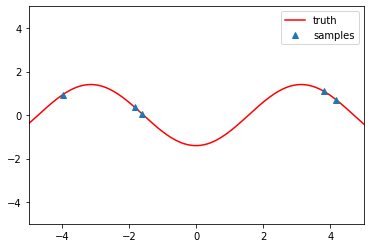

In [41]:
def _test_plotting():
    batch = generate_sinusoid_batch(3, 5)
    plot_task(batch, 0)

_test_plotting()

In [42]:
def get_device():
    """Standard device on which to run computations."""
    return torch.device('cuda:1')


@contextlib.contextmanager
def model_eval(model):
    """Enter 'evaluation mode' for the given model. """
    model.eval()  # DANGER: This *mutates* the model. It returns a reference to itself
    try:
        yield
    finally:
        model.train()


def _module_device(module: torch.nn.Module):
    """Find the pytorch device to which the given module is bound."""
    devices = {x.device for x in module.parameters()}
    if len(devices) != 1:
        raise ValueError(f"Found candidate devices {devices}")
    return next(iter(devices))


def _batch_to_x_y(batch: Batch, device) -> Tuple[torch.Tensor, torch.Tensor]:
    """Convert the given batch to x & y torch tensors."""
    x = torch.tensor(batch.x.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    y = torch.tensor(batch.y.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    return x, y


def _get_prediction_mse(module: torch.nn.Module, batch: Batch) -> torch.Tensor:
    """Get the MSE, as a tensor, for this module & batch."""
    device = _module_device(module)
    x, y = _batch_to_x_y(batch, device)

    # Forward pass: Compute predicted y by passing x to the model
    y_pred = module(x)
    
    # Compute loss.
    return torch.nn.functional.mse_loss(y_pred, y)


def _train_step(module: torch.nn.Module, train_batch: Batch, optimizer):
    loss = _get_prediction_mse(module, train_batch)

    # Zero gradients, perform a backward pass (compute gradients wrt. the loss), and update the 
    # weights accordingly.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

def _get_prediction(module: torch.nn.Module, x: numpy.ndarray) -> numpy.ndarray:
    device = _module_device(module)
    torch_x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad(), model_eval(module):
        torch_y = module(torch_x)
    return torch_y.cpu().numpy().squeeze(1)
    
    
class BatchPrediction(NamedTuple):
    y: numpy.ndarray
    mse_loss: float

    
def _get_test_prediction(module, test_batch: Batch) -> BatchPrediction:
    """Get the prediction when evaluating the module on the given batch."""
    device = _module_device(module)
    x, y = _batch_to_x_y(test_batch, device)

    # No need to accumulate gradients when evaluating the validation loss.
    # Also, we put the model into "evaluation mode" for the purpose of computing the prediction.
    # This is to prevent layers like BatchNorm / Dropout mutating their internal state.
    with torch.no_grad(), model_eval(module):
        y_pred = module(x)
        test_mse = torch.nn.functional.mse_loss(y_pred, y).item()
        
    return BatchPrediction(y_pred.cpu().numpy().squeeze(1), test_mse)


def pretrain_example(
        *,
        num_steps_train: int = 70000,
        batch_size_meta: int = 25,
        batch_size_inner: int = 10,
        learning_rate: float = 0.001,
        verbose: bool = False) -> Tuple[list, torch.nn.Module]:
    """Perform pre-training.

    :param num_steps_train: The number of pre-training steps to perform.
    :param batch_size_meta: The number of tasks in each meta-batch.
    :param batch_size_inner: The size of the training set. We actually generate *twice* this amount of data in total;
     half is used for the inner training loop, and the other half for inner testing.
    :param learning_rate: Learning rate used for the meta-optimiser.
    :param verbose: Whether to perform additional printing.
    """
    device = get_device()
    module = SinusoidalLearner().to(device)
    
    if verbose:
        print(module)

    # Construct an Optimizer. The call to model.parameters() in the constructor will contain the
    # learnable parameters of the module.
    optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
    
    # These are the MSEs from the 'test' part of the batches drawn within the meta-training process.
    meta_train_test_mses = []

    numpy.random.seed(42)
    
    with Timer() as timer:
        for i_meta in range(num_steps_train):
            
            # Generate a batch with which to train.
            batch = generate_sinusoid_batch(batch_size_meta, batch_size_inner * 2)
            
            train_batch = batch[:batch_size_inner]
            test_batch = batch[batch_size_inner:]
            
            _train_step(module, train_batch, optimizer)

            if i_meta % 500 == 0:
                prediction = _get_test_prediction(module, test_batch)
                meta_train_test_mses.append(prediction.mse_loss)
                if verbose:
                    print(f'Epoch {i_meta + 1}/{num_steps_train}:   {prediction.mse_loss}')

    print(timer)
    
    return meta_train_test_mses, module

In [55]:
meta_train_test_mses_pretrain, module_pretrain = pretrain_example()

85.799


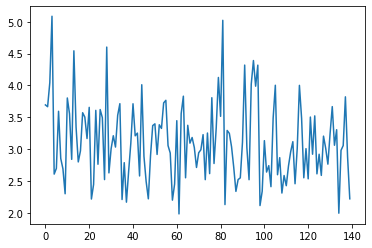

In [56]:
pyplot.plot(meta_train_test_mses_pretrain)

In [47]:
def meta_test_batch(
        module: torch.nn.Module,
        batch: Batch,
        learning_rate: float,
        base_color: str):
    # We need to make an independent copy of the module's parameters before we mutate them in training.
    # This seems like an incredibly blunt way of achieving this, but it seems to work.
    module = copy.deepcopy(module)
    
    test_x = numpy.linspace(_DEFAULT_INPUT_RANGE[0], _DEFAULT_INPUT_RANGE[1])
    
    y = _get_prediction(module, test_x)
    
    plot_task(batch, 0)
    pyplot.plot(test_x, y, '-', c=f'light{base_color}', ls='dotted', alpha=0.5, label='pre-update')
    
    # Now perform a small number of learning updates on the batch, plotting how our prediction evolves.
    optimizer = torch.optim.SGD(module.parameters(), lr=learning_rate)
    
    _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c=base_color, ls='dotted', alpha=0.5, label='1 grad step')
    
    for _ in range(9):
        _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c=base_color, ls='-.', alpha=0.6, label='10 grad steps')
    
#     for _ in range(10):
#         _train_step(module, batch, optimizer)
#     y = _get_prediction(module, test_x)
#     pyplot.plot(test_x, y, '-', c='darkblue', ls='dashed', alpha=0.9, label='20 grad steps')

    batch_size_inner = batch.x.shape[1]
    pyplot.title(f'K = {batch_size_inner}, LR = {learning_rate}')
    pyplot.legend()
    pyplot.tight_layout()

    
def meta_test(
        module,
        *,
        batch_size_inner: int = 10,
        input_range: tuple = _DEFAULT_INPUT_RANGE,
        learning_rate: float = 0.001,
        base_color: str = 'blue'):
    """Perform a single test on the trained module"""
    # A batch of data on which we shall be testing.
    batch = generate_sinusoid_batch(1, batch_size_inner, input_range=input_range)
    meta_test_batch(module, batch, learning_rate, base_color)

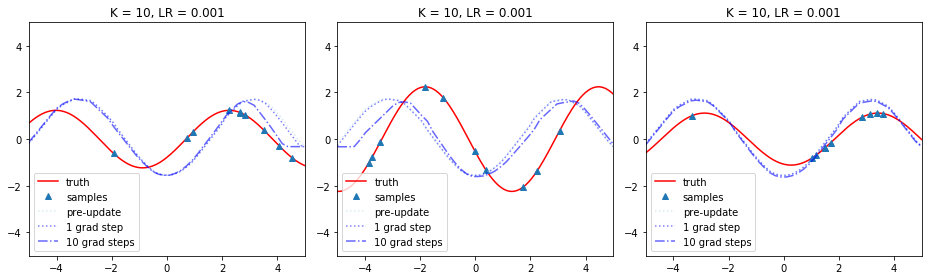

In [48]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain)

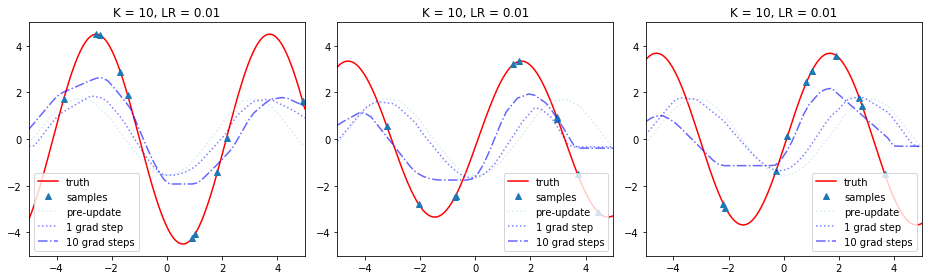

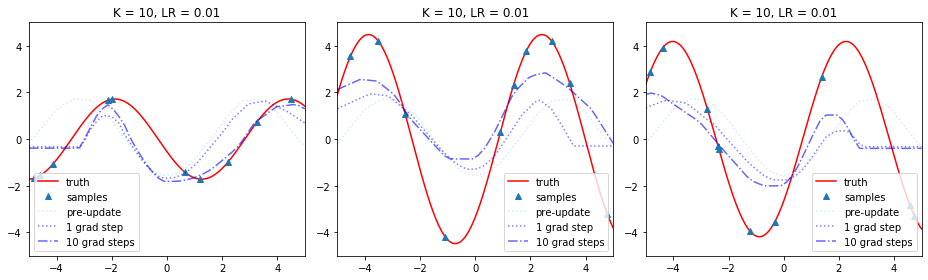

In [49]:
for _ in axes_iter(range(6)):
    meta_test(module_pretrain, learning_rate=0.01)

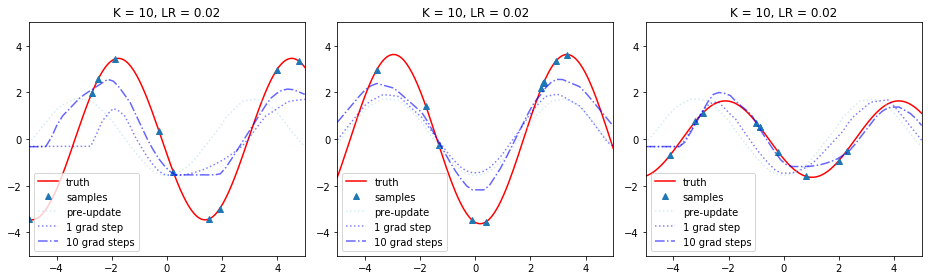

In [50]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain, learning_rate=0.02)

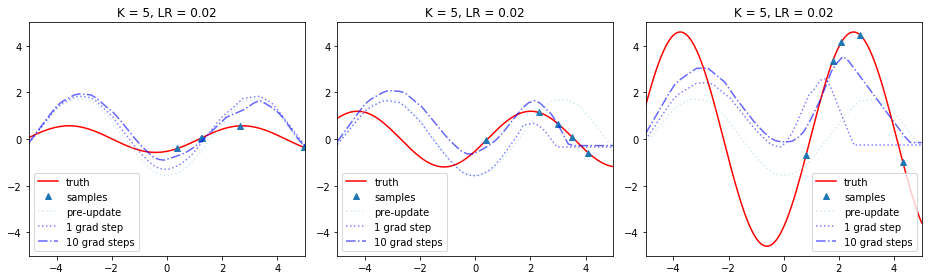

In [51]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain, batch_size_inner=5, input_range=(0, 5), learning_rate=0.02)

In [136]:
def maml_train(
        *,
        num_steps_meta: int = 70000,
        num_steps_inner: int = 1,
        batch_size_meta: int = 25,
        batch_size_inner: int = 10,
        learning_rate_meta: float = 0.001,  # Meta Adam optimizer
        learning_rate_inner: float = 0.01,  # Inner SGD optimizer
        first_order: bool = False,  # Should we apply the first-order approximation?
        verbose: bool = False) -> Tuple[list, torch.nn.Module]:
    device = get_device()
    module = SinusoidalLearner().to(device)
    
    if verbose:
        print(module)

    # Construct an Optimizer. The call to model.parameters() in the constructor will contain the
    # learnable parameters of the module.
    meta_optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate_meta)
    
    # These are the MSEs from the 'test' part of the batches drawn within the meta-training process.
    meta_train_test_mses = []

    numpy.random.seed(42)  # FIXME This shouldn't live here.
    
    with Timer() as timer:
        for i_meta in range(num_steps_meta):
            
            # Generate a batch with which to train.
            batch = generate_sinusoid_batch(batch_size_meta, batch_size_inner * 2)
            
            train_batch = batch[:batch_size_inner]
            test_batch = batch[batch_size_inner:]
            
            total_losses = []
            for i_task in range(batch_size_meta):
                # 0. Get task-specific batches
                task_train_batch = train_batch.for_task(i_task)
                task_test_batch = test_batch.for_task(i_task)
                
                # 1. Forward on the original module
                loss = _get_prediction_mse(module, task_train_batch)
                
                # 2. Use gradients to build *new* parameters
                # create_graph=True is required for allowing higher-order derivatives. Note that we
                # get the wrong answer below if we set it to False! NB - we *may* in practice want to experiment 
                # with setting it to False, though. 
                # Effectively this would drop second-order terms when we come to perform the meta-training step.
                d_loss_d_parameters = torch.autograd.grad(
                    [loss],
                    module.parameters(),
                    create_graph=not first_order)
                
                parameter_to_replacement = {
                    parameter: parameter - learning_rate_inner * d_loss_d_parameter
                    for parameter, d_loss_d_parameter in zip(module.parameters(), d_loss_d_parameters)
                }
                
                if num_steps_inner != 1:
                    raise NotImplementedError
                
                # 3. Forward with new parameters on test batch to build loss used in meta-train step.
                x, y = _batch_to_x_y(task_test_batch, device)
                y_pred = module.forward_with_parameter_replacement(x, parameter_to_replacement)
                total_losses.append(torch.nn.functional.mse_loss(y_pred, y))

            # Whilst the paper uses a sum, in practice the reference implementation uses a mean.
            total_loss = sum(total_losses) / batch_size_meta

            # Apply the meta-optimisation step to the module parameters.
            meta_optimizer.zero_grad()
            total_loss.backward()
            meta_optimizer.step()
            
            if i_meta % 100 == 0:
                mse_loss = total_loss.item()
                meta_train_test_mses.append(mse_loss)
                if verbose:
                    print(f'Epoch {i_meta + 1}/{num_steps_meta}:   {mse_loss}')

    print(timer)
    
    return meta_train_test_mses, module

In [137]:
# meta_train_test_mses_maml, module_maml = maml_train(verbose=True)
# torch.save(module_maml.state_dict(), 'module_maml_70k_state.pt')
meta_train_test_mses_maml, module_maml = maml_train(first_order=True, verbose=True)
torch.save(module_maml.state_dict(), 'module_maml_firstorder_70k_state.pt')

SinusoidalLearner(
  (layer_0): Linear(in_features=1, out_features=40, bias=True)
  (layer_1): Linear(in_features=40, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=1, bias=True)
)
Epoch 1/70000:   3.698856830596924
Epoch 101/70000:   4.236112594604492
Epoch 201/70000:   2.916607618331909
Epoch 301/70000:   2.853118896484375
Epoch 401/70000:   2.7162599563598633
Epoch 501/70000:   3.444308280944824
Epoch 601/70000:   3.485163688659668
Epoch 701/70000:   3.0915703773498535
Epoch 801/70000:   2.8319809436798096
Epoch 901/70000:   2.575892686843872
Epoch 1001/70000:   3.6399385929107666
Epoch 1101/70000:   3.2194764614105225
Epoch 1201/70000:   2.5551366806030273
Epoch 1301/70000:   2.7533371448516846
Epoch 1401/70000:   2.7467541694641113
Epoch 1501/70000:   4.709664344787598
Epoch 1601/70000:   2.825680732727051
Epoch 1701/70000:   2.4335782527923584
Epoch 1801/70000:   2.328258991241455
Epoch 1901/70000:   3.46917462348938
Epoch 2001/70000:   1.58483421802

Epoch 20401/70000:   0.6359655261039734
Epoch 20501/70000:   0.8661538362503052
Epoch 20601/70000:   0.7040650248527527
Epoch 20701/70000:   0.9040622711181641
Epoch 20801/70000:   1.3135217428207397
Epoch 20901/70000:   0.7027590274810791
Epoch 21001/70000:   0.8715417385101318
Epoch 21101/70000:   0.9243296384811401
Epoch 21201/70000:   0.921687126159668
Epoch 21301/70000:   1.315505027770996
Epoch 21401/70000:   0.8211957216262817
Epoch 21501/70000:   0.8109061121940613
Epoch 21601/70000:   1.121683955192566
Epoch 21701/70000:   0.9958332777023315
Epoch 21801/70000:   0.6808053255081177
Epoch 21901/70000:   0.6088954210281372
Epoch 22001/70000:   1.278639554977417
Epoch 22101/70000:   0.9266762137413025
Epoch 22201/70000:   1.0250227451324463
Epoch 22301/70000:   0.9530407786369324
Epoch 22401/70000:   0.8900893926620483
Epoch 22501/70000:   0.6314130425453186
Epoch 22601/70000:   0.7437682151794434
Epoch 22701/70000:   0.9689484238624573
Epoch 22801/70000:   0.9928087592124939
Epoc

Epoch 40901/70000:   0.3275831639766693
Epoch 41001/70000:   0.49183377623558044
Epoch 41101/70000:   0.7301467061042786
Epoch 41201/70000:   0.566095232963562
Epoch 41301/70000:   0.9314953684806824
Epoch 41401/70000:   0.557948887348175
Epoch 41501/70000:   0.3983003497123718
Epoch 41601/70000:   0.7038116455078125
Epoch 41701/70000:   0.46950259804725647
Epoch 41801/70000:   0.429005891084671
Epoch 41901/70000:   0.8119642734527588
Epoch 42001/70000:   0.6345552802085876
Epoch 42101/70000:   0.5550587177276611
Epoch 42201/70000:   0.38076895475387573
Epoch 42301/70000:   0.609419584274292
Epoch 42401/70000:   0.5462373495101929
Epoch 42501/70000:   0.4328625500202179
Epoch 42601/70000:   0.5876873731613159
Epoch 42701/70000:   0.3632177412509918
Epoch 42801/70000:   0.2758556008338928
Epoch 42901/70000:   0.6947250366210938
Epoch 43001/70000:   0.4261552095413208
Epoch 43101/70000:   0.3721734583377838
Epoch 43201/70000:   0.3560449481010437
Epoch 43301/70000:   0.3157680332660675
E

Epoch 61401/70000:   0.44590580463409424
Epoch 61501/70000:   0.3215501010417938
Epoch 61601/70000:   0.4354163706302643
Epoch 61701/70000:   0.5061496496200562
Epoch 61801/70000:   0.4697779715061188
Epoch 61901/70000:   0.49824628233909607
Epoch 62001/70000:   0.3926143944263458
Epoch 62101/70000:   0.5083516240119934
Epoch 62201/70000:   0.3875598907470703
Epoch 62301/70000:   0.44929611682891846
Epoch 62401/70000:   0.44199731945991516
Epoch 62501/70000:   0.47331979870796204
Epoch 62601/70000:   0.42646467685699463
Epoch 62701/70000:   0.4178621172904968
Epoch 62801/70000:   0.7171730399131775
Epoch 62901/70000:   0.513908326625824
Epoch 63001/70000:   0.3450954854488373
Epoch 63101/70000:   0.41227835416793823
Epoch 63201/70000:   0.43915680050849915
Epoch 63301/70000:   0.3757103383541107
Epoch 63401/70000:   0.51450115442276
Epoch 63501/70000:   0.3415634334087372
Epoch 63601/70000:   0.522919774055481
Epoch 63701/70000:   0.37587204575538635
Epoch 63801/70000:   0.507199466228

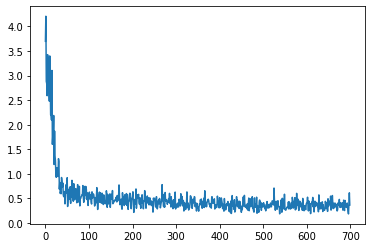

In [125]:
pyplot.plot(meta_train_test_mses_maml)

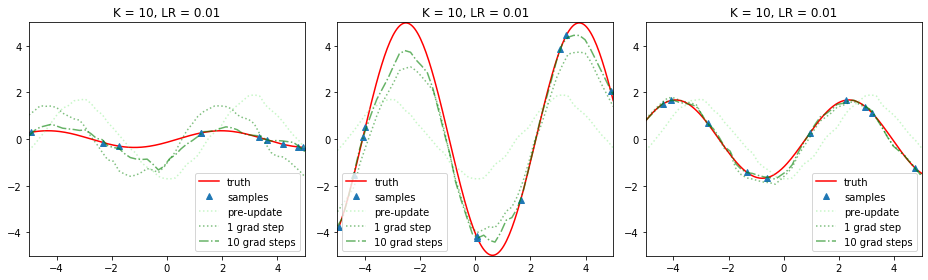

In [52]:
for _ in axes_iter(range(3)):
    meta_test(module_maml, learning_rate=0.01, base_color='green')

In [37]:
def meta_test_multi(
        module_maml: torch.nn.Module,
        module: torch.nn.Module,
        *,
        batch_size_inner: int = 10,
        input_range: tuple = _DEFAULT_INPUT_RANGE,
        learning_rate: float = 0.01):
    """Perform a single test on the trained module"""
    batch = generate_sinusoid_batch(1, batch_size_inner, input_range=input_range)
    for (mod, color) in axes_iter([(module_maml, 'green'), (module, 'blue')], num_cols=2, width=10, height=3.5):
        meta_test_batch(mod, batch, learning_rate, base_color=color)

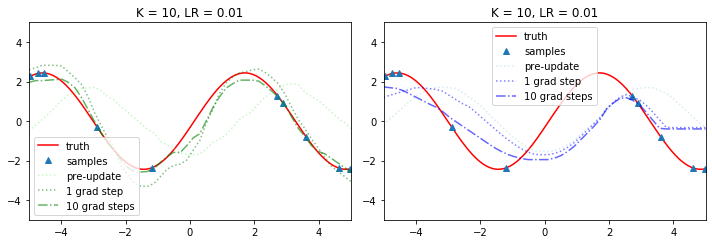

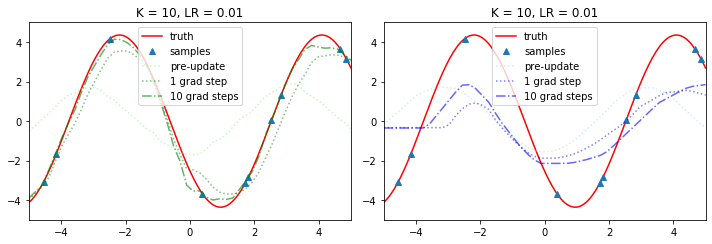

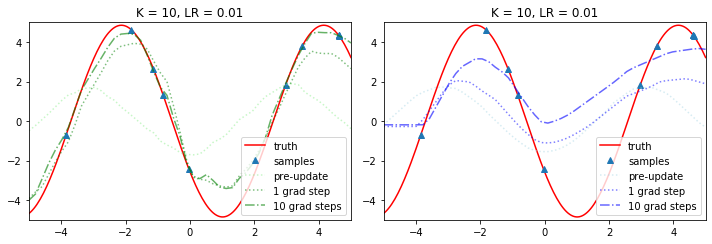

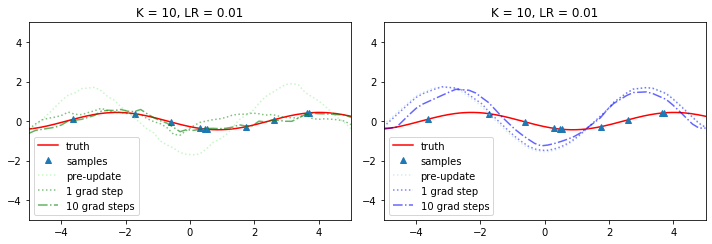

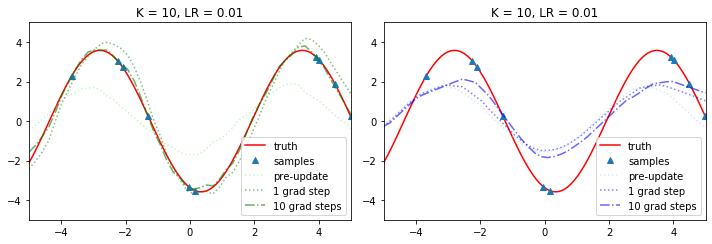

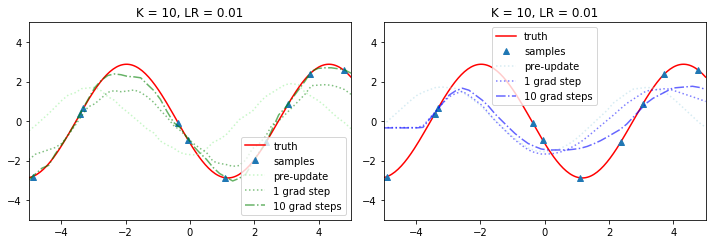

In [53]:
for _ in range(6):
    meta_test_multi(module_maml, module_pretrain, learning_rate=0.01)

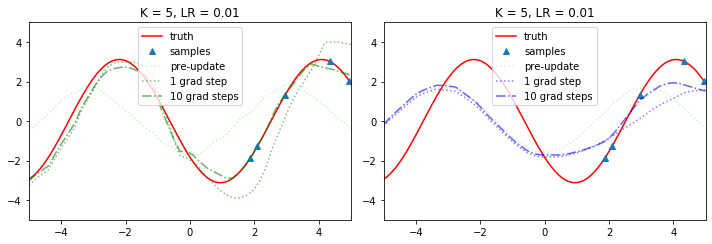

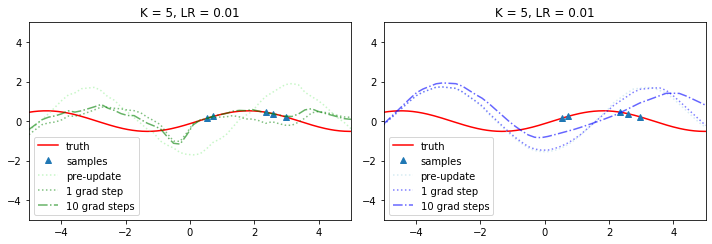

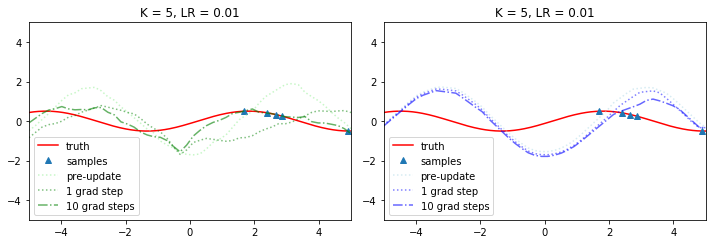

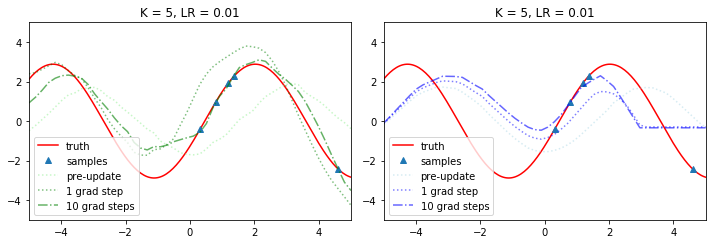

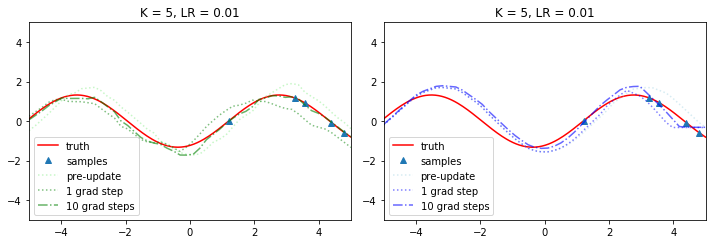

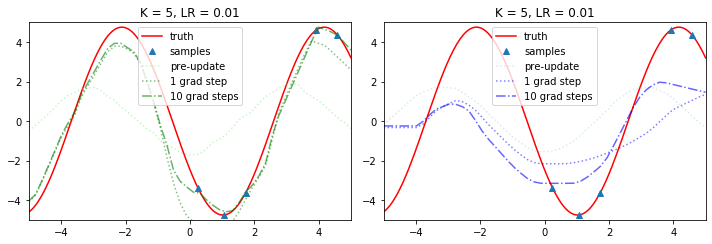

In [54]:
for _ in range(6):
    meta_test_multi(
        module_maml,
        module_pretrain,
        learning_rate=0.01,
        batch_size_inner=5,
        input_range=(0, 5))

In [26]:
module_maml_loaded = SinusoidalLearner()
module_maml_loaded.load_state_dict(torch.load('module_maml_70k_state.pt'))
module_maml = module_maml_loaded
print(module_maml_loaded)

SinusoidalLearner(
  (layer_0): Linear(in_features=1, out_features=40, bias=True)
  (layer_1): Linear(in_features=40, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=1, bias=True)
)


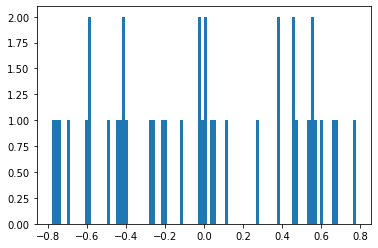

In [31]:
pyplot.hist(module_maml.layer_0.weight.data.cpu().numpy().ravel(), bins=100);

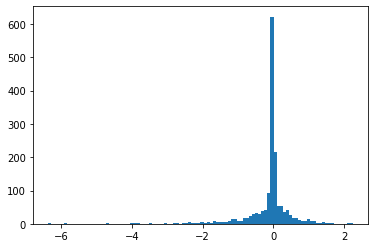

In [32]:
pyplot.hist(module_maml.layer_1.weight.data.cpu().numpy().ravel(), bins=100);

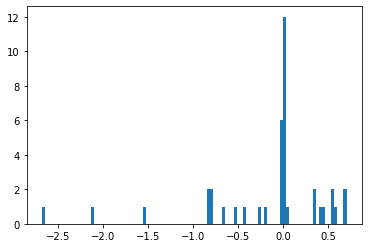

In [33]:
pyplot.hist(module_maml.layer_2.weight.data.cpu().numpy().ravel(), bins=100);

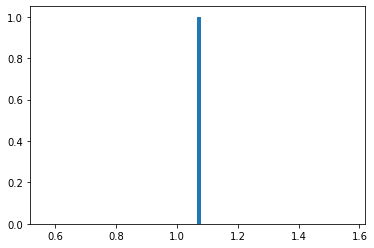

In [34]:
pyplot.hist(module_maml.layer_2.bias.data.cpu().numpy().ravel(), bins=100);

